<a href="https://colab.research.google.com/github/2303A52161/AI-Playlist-Generator-code/blob/main/Copy_of_RL_Playlist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic setup
!pip install pandas numpy matplotlib
!pip install datasets  # for loading from Hugging Face

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install torch torchvision torchaudio pandas numpy matplotlib datasets scikit-learn -q


In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from datasets import load_dataset
from collections import deque
import matplotlib.pyplot as plt

# -------------------------------------------------------
# STEP 1: Load the Full Dataset (Not sampled yet)
# -------------------------------------------------------

dataset = load_dataset("maharshipandya/spotify-tracks-dataset")
df = dataset["train"].to_pandas()

# Keep relevant columns only
cols = ['track_id','track_name','artists','track_genre','tempo','energy','valence','acousticness','popularity']
df = df[cols].rename(columns={'track_genre':'genre','artists':'artist_name'})

df.dropna(subset=['tempo','energy','valence','popularity'], inplace=True)

print("✅ Columns ready:", df.columns.tolist())

print(f"Loaded full dataset with {len(df)} tracks ✅")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset.csv:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/114000 [00:00<?, ? examples/s]

✅ Columns ready: ['track_id', 'track_name', 'artist_name', 'genre', 'tempo', 'energy', 'valence', 'acousticness', 'popularity']
Loaded full dataset with 114000 tracks ✅


In [ ]:
# -------------------------------------------------------
# STEP 2: Improved Genre Mapping (fixes 'other' issue)
# -------------------------------------------------------

def simplify_genre(g):
    g = g.lower().strip()

    if any(x in g for x in ["pop", "dance pop", "power pop", "pop edm", "synthpop"]):
        return "pop"
    elif any(x in g for x in ["rock", "metal", "punk", "grunge", "garage"]):
        return "rock"
    elif any(x in g for x in ["hip", "rap", "r&b", "trap", "drill", "urban"]):
        return "hiphop"
    elif any(x in g for x in ["jazz", "blues", "soul", "funk"]):
        return "jazz_blues"
    elif any(x in g for x in ["classical", "piano", "instrumental", "orchestra", "opera"]):
        return "classical"
    elif any(x in g for x in ["edm", "electronic", "house", "trance", "techno", "dubstep", "club", "ambient", "chill", "lofi"]):
        return "edm"
    elif any(x in g for x in ["acoustic", "mellow", "soft", "singer-songwriter"]):
        return "acoustic"
    elif any(x in g for x in ["indie", "alternative", "alt", "post-"]):
        return "indie"
    elif any(x in g for x in ["anime", "game", "soundtrack", "score"]):
        return "anime"
    elif any(x in g for x in ["world", "brazil", "afro", "latin", "reggae", "dub", "caribbean", "samba"]):
        return "world_music"
    elif any(x in g for x in ["folk", "country", "bluegrass", "americana"]):
        return "folk"
    else:
        return "other"


In [ ]:
# -------------------------------------------------------
# STEP 3: Sample 15,000 balanced tracks
# -------------------------------------------------------
# Load more data (bigger pool)

df = df.sample(n=15000, random_state=42).reset_index(drop=True)

In [ ]:
df['genre'] = df['genre'].apply(simplify_genre)

In [ ]:
df = df[df['genre'] != 'other']


In [ ]:
print(df['genre'].value_counts())


genre
rock           2124
edm            1835
pop            1226
world_music    1173
jazz_blues      562
folk            413
classical       397
acoustic        262
indie           261
hiphop          135
anime           130
Name: count, dtype: int64


In [ ]:
df.head(20)

,track_id,track_name,artist_name,genre,tempo,energy,valence,acousticness,popularity
0,6KwkVtXm8OUp2XffN5k7lY,No Other Name,Hillsong Worship,world_music,148.014,0.598,0.0466,0.005110,50
3,75hT0hvlESnDJstem0JgyR,Merry Christmas,Bryan Adams,rock,109.991,0.511,0.5980,0.406000,0
5,2zQt5C0AIv27RhfJCRZdZ4,"Jah Jah Revolta, Pt. 2",BaianaSystem,world_music,143.989,0.800,0.5830,0.006310,38
7,1LDQFdGTEXOnycDC8CJ5p1,A Form of Protest,Cane Hill,rock,92.530,0.933,0.1940,0.000009,54
10,4ifiz8TRTNdG9ORNWh2P0Q,I'll Be Home For Christmas - From The Kacey Mu...,Kacey Musgraves;Lana Del Rey,folk,139.592,0.183,0.3810,0.829000,0
11,5xWxnLpw8ooMW1nJwY2hui,時間がない,KIRINJI,pop,126.033,0.675,0.6800,0.124000,0
14,5pq4v03P5PxMcnCagg4S3Z,In Case You Didn’t Know,Boyce Avenue,acoustic,147.549,0.299,0.3410,0.833000,60
16,198v7BbjXn2GTeI4NkBN39,Vi Mamãe Oxum Na Cachoeira - Live,Mariene De Castro,world_music,126.911,0.697,0.8150,0.750000,39
18,0b11D9D0hMOYCIMN3OKreM,Into Your Arms (feat. Ava Max),Witt Lowry;Ava Max,pop,170.039,0.788,0.2280,0.013400,77
19,2pXg8l1JGZ3hCyFqxirV13,Mocca,Lalo Ebratt;Trapical,world_music,97.956,0.696,0.5910,0.183000,0


🧩 STEP 1 — Encode Genres and Normalize Features

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Encode genre labels to numbers
genre_enc = LabelEncoder()
df['genre_code'] = genre_enc.fit_transform(df['genre'])

# Select features for DQN input
features = ['tempo','energy','valence','acousticness','popularity','genre_code']

# Normalize features (scale between 0–1)
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

print("✅ Features encoded and scaled.")
print(df[features].head())


✅ Features encoded and scaled.
       tempo    energy   valence  acousticness  popularity  genre_code
0   0.517211  0.596349  0.044410      0.005131    0.515464         1.0
3   0.324704  0.508992  0.602343      0.407631    0.000000         0.9
5   0.496833  0.799179  0.587166      0.006335    0.391753         1.0
7   0.236301  0.932725  0.193557      0.000009    0.556701         0.9
10  0.474572  0.179645  0.382772      0.832329    0.000000         0.4


⚙️ STEP 2 — Define the DQN Neural Network

In [ ]:
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, action_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
def compute_reward(song1, song2):
    # Calculate smoothness (closer tempo, energy, valence = smoother)
    diff = (
        abs(song1['tempo'] - song2['tempo'])
        + abs(song1['energy'] - song2['energy'])
        + abs(song1['valence'] - song2['valence'])
    )
    smoothness = 1 - diff / 3  # normalized 0–1

    # Encourage diversity (different genre = 1)
    diversity = 1 if song1['genre'] != song2['genre'] else 0

    # Popularity (already normalized 0–1)
    popularity = song2['popularity']

    # Weighted sum of objectives
    reward = (0.4 * smoothness) + (0.4 * diversity) + (0.2 * popularity)
    return reward


In [ ]:
def compute_reward(song1, song2):
    # Multi-objective: smoothness + diversity + popularity
    diff = abs(song1['tempo'] - song2['tempo']) + abs(song1['energy'] - song2['energy']) + abs(song1['valence'] - song2['valence'])
    smoothness = 1 - diff / 3
    diversity = 1 if song1['genre'] != song2['genre'] else 0
    popularity = song2['popularity']
    return 0.5*smoothness + 0.3*diversity + 0.2*popularity


In [ ]:
state_dim = len(features)
action_dim = len(df)

q_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)
target_net.load_state_dict(q_net.state_dict())

optimizer = torch.optim.Adam(q_net.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

print("✅ Model and reward function ready for training!")


✅ Model and reward function ready for training!



🚀 Deep Q-Learning Training Started...

Ep 0000/2000 | Reward: 28.661| Buffer: 39 | Elapsed: 0.0 min
Ep 0050/2000 | Reward: 30.059| Buffer: 1989 | Elapsed: 0.3 min
Ep 0100/2000 | Reward: 31.757| Buffer: 3939 | Elapsed: 0.6 min
Ep 0150/2000 | Reward: 28.821| Buffer: 5889 | Elapsed: 0.9 min
Ep 0200/2000 | Reward: 28.744| Buffer: 7839 | Elapsed: 1.1 min
Ep 0250/2000 | Reward: 28.846| Buffer: 9789 | Elapsed: 1.4 min
Ep 0300/2000 | Reward: 27.630| Buffer: 11739 | Elapsed: 1.8 min
Ep 0350/2000 | Reward: 26.414| Buffer: 13689 | Elapsed: 2.0 min
Ep 0400/2000 | Reward: 27.434| Buffer: 15000 | Elapsed: 2.3 min
Ep 0450/2000 | Reward: 25.819| Buffer: 15000 | Elapsed: 2.6 min
Ep 0500/2000 | Reward: 27.895| Buffer: 15000 | Elapsed: 2.9 min
Ep 0550/2000 | Reward: 29.635| Buffer: 15000 | Elapsed: 3.2 min
Ep 0600/2000 | Reward: 23.845| Buffer: 15000 | Elapsed: 3.5 min
Ep 0650/2000 | Reward: 27.495| Buffer: 15000 | Elapsed: 3.8 min
Ep 0700/2000 | Reward: 25.365| Buffer: 15000 | Elapsed: 4.1 min
Ep 0750/

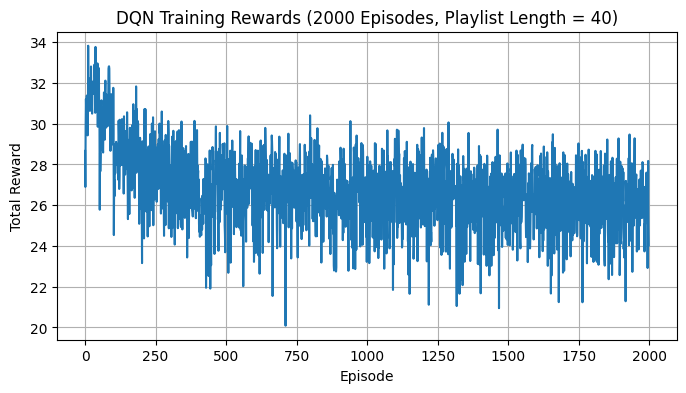

In [ ]:
import time
from collections import deque
import random
import numpy as np
import torch.optim as optim

# ✅ Configuration
episodes = 2000            # 600 episodes (~10–15 min)
playlist_len = 40         # longer sequences = better learning
epsilon = 0.2               # exploration rate
gamma = 0.9
batch_size = 64
target_update = 50          # update target net every 20 episodes
replay_buffer = deque(maxlen=15000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Model, optimizer, and loss function initialization (moved outside the loop)
q_net = DQN(len(features), len(df)).to(device)
target_net = DQN(len(features), len(df)).to(device)
target_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()


def get_state(song):
    # Ensure the selected features are converted to a numpy array of float32 before creating the tensor
    return torch.tensor(song[features].values.astype(np.float32), dtype=torch.float32).unsqueeze(0).to(device)

rewards_per_episode = []
start_time = time.time()

print("\n🚀 Deep Q-Learning Training Started...\n")

for ep in range(episodes):
    # Start from a random song
    idx = random.randint(0, len(df) - 1)
    cur_song = df.iloc[idx]
    total_reward = 0

    for _ in range(playlist_len - 1):
        state = get_state(cur_song)

        # ε-greedy action selection
        if random.random() < epsilon:
            next_idx = random.randint(0, len(df) - 1)
        else:
            with torch.no_grad():
                q_values = q_net(state)
                next_idx = torch.argmax(q_values).item()

        next_song = df.iloc[next_idx]
        reward = compute_reward(cur_song, next_song)
        total_reward += reward
        next_state = get_state(next_song)

        # Store transition
        replay_buffer.append((state, next_idx, reward, next_state))
        cur_song = next_song

        # Train multiple times per step (3x)
        for _ in range(3):
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states = torch.cat([b[0] for b in batch])
                actions = torch.tensor([b[1] for b in batch]).long().to(device)
                rewards = torch.tensor([b[2] for b in batch]).float().to(device)
                next_states = torch.cat([b[3] for b in batch])

                # Q(s,a)
                q_pred = q_net(states).gather(1, actions.view(-1,1)).squeeze()

                # target = r + γ * max(Q'(s'))
                with torch.no_grad():
                    q_next = target_net(next_states).max(1)[0]
                    q_target = rewards + gamma * q_next

                loss = loss_fn(q_pred, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    rewards_per_episode.append(total_reward)

    # Update target network
    if ep % target_update == 0:
        target_net.load_state_dict(q_net.state_dict())

    # Print every 20 episodes
    if ep % 50 == 0:
        elapsed = (time.time() - start_time) / 60
        print(f"Ep {ep:04d}/{episodes} | Reward: {total_reward:.3f}| Buffer: {len(replay_buffer)} | Elapsed: {elapsed:.1f} min")

print("\n✅ Training Completed!")
print(f"⏱️ Total Time: {(time.time()-start_time)/60:.1f} minutes")

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(rewards_per_episode)
plt.title("DQN Training Rewards (2000 Episodes, Playlist Length = 40)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

playlist_len = 12  # songs per playlist

# track visited indices to prevent repeats
visited = set()
idx = random.randint(0, len(df)-1)
cur_song = df.iloc[idx]
playlist = [cur_song]
visited.add(idx)

for _ in range(playlist_len - 1):
    state = get_state(cur_song)
    with torch.no_grad():
        q_values = q_net(state).cpu().numpy().flatten()

    # Mask already-visited songs
    q_values[list(visited)] = -np.inf

    # Softmax sampling with adjusted temperature
    temperature = 1.0  # Increased temperature for smoother probabilities
    probs = np.exp(q_values / temperature)

    # Add a small epsilon to the sum to prevent division by zero
    sum_probs = np.nansum(probs)
    if sum_probs == 0:
        # If all probabilities are zero after masking, choose a random unvisited song
        available_indices = [i for i in range(len(df)) if i not in visited]
        if not available_indices:
             # If no unvisited songs are available, break the loop
             break
        next_idx = random.choice(available_indices)
    else:
        probs = probs / (sum_probs + 1e-9) # Add epsilon for numerical stability

        # Handle potential NaN values after normalization
        if np.isnan(probs).any():
             # If NaNs still exist, fall back to a safer sampling method (e.g., uniform from unvisited)
             available_indices = [i for i in range(len(df)) if i not in visited]
             if not available_indices:
                  break
             next_idx = random.choice(available_indices)
        else:
             next_idx = np.random.choice(len(q_values), p=probs)


    next_song = df.iloc[next_idx]
    playlist.append(next_song)
    visited.add(next_idx)
    cur_song = next_song

playlist_df = pd.DataFrame(playlist)
print("\n🎧 Generated Personalized Playlist:")
display(playlist_df[['track_name', 'artist_name', 'genre', 'tempo', 'energy', 'valence', 'popularity']])


🎧 Generated Personalized Playlist:


,track_name,artist_name,genre,tempo,energy,valence,popularity
3281,FIREBALL,B'z,pop,0.264243,0.925696,0.512289,0.371134
12666,Cilada,Katinguelê,world_music,0.198046,0.594341,0.616509,0.381443
11401,Vive La Vida,Chino & Nacho;Sixto Rein,world_music,0.390684,0.946782,0.900839,0.010309
8561,Una Noche Más,Mariah Angeliq,world_music,0.258892,0.662620,0.627640,0.000000
10280,Seek Bromance - Avicii Vocal Edit,Tim Berg;Avicii,edm,0.405579,0.810224,0.550739,0.587629
8085,Down In The Valley,The Devil Makes Three,folk,0.367137,0.582292,0.819891,0.268041
12695,Querida Rosa,Cami,world_music,0.475544,0.331265,0.384796,0.051546
9645,Teu Reino - Acústico,Cristo Vivo,world_music,0.455677,0.497947,0.161177,0.453608
14111,Crazy What Love Can Do,David Guetta;Becky Hill;Ella Henderson,pop,0.389920,0.711821,0.466756,0.020619
14565,Pasos - Remasterizado 2007,Soda Stereo,rock,0.217953,0.579279,0.357476,0.402062


In [ ]:
print("✅ Using device:", device)


✅ Using device: cuda


In [ ]:
save_path = "/content/drive/MyDrive/PlaylistRL_Model/"
import os
os.makedirs(save_path, exist_ok=True)


In [ ]:
model_path = os.path.join(save_path, "trained_dqn_playlist_model.pth")

torch.save({
    'q_net_state_dict': q_net.state_dict(),
    'target_net_state_dict': target_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'features': features,
    'genre_encoder_classes': genre_enc.classes_ if 'genre_enc' in locals() else None
}, model_path)

print(f"✅ Model saved to Google Drive at: {model_path}")


✅ Model saved to Google Drive at: /content/drive/MyDrive/PlaylistRL_Model/trained_dqn_playlist_model.pth


In [ ]:
# ✅ Rebuild model with current dataset size
q_net = DQN(len(checkpoint['features']), len(df)).to(device)

# ✅ Load only matching layers (skip mismatched output)
state_dict = checkpoint['q_net_state_dict']
model_dict = q_net.state_dict()

filtered = {k: v for k, v in state_dict.items()
            if k in model_dict and model_dict[k].shape == v.shape}

model_dict.update(filtered)
q_net.load_state_dict(model_dict)

print("✅ Loaded hidden layers; re-initialized new output layer for", len(df), "songs")


✅ Loaded hidden layers; re-initialized new output layer for 114000 songs


In [ ]:
target_net = DQN(len(checkpoint['features']), len(df)).to(device)
target_net.load_state_dict(q_net.state_dict())
optimizer = torch.optim.Adam(q_net.parameters(), lr=5e-4)

print("✅ Ready to retrain on your new dataset!")


✅ Ready to retrain on your new dataset!


✅ Using device: cuda
✅ Loaded dataset with 8518 tracks
✅ Checkpoint loaded from Drive
✅ Hidden layers restored; output layer reset for 8518 songs

🚀 Deep Q-Learning Retraining Started...

Ep 0000/4500 | Reward: 33.327 | Buffer: 39 | Elapsed: 0.0 min
Ep 0050/4500 | Reward: 24.733 | Buffer: 1989 | Elapsed: 0.3 min
Ep 0100/4500 | Reward: 27.834 | Buffer: 3939 | Elapsed: 0.6 min
Ep 0150/4500 | Reward: 36.655 | Buffer: 5889 | Elapsed: 0.8 min
Ep 0200/4500 | Reward: 27.747 | Buffer: 7839 | Elapsed: 1.1 min
Ep 0250/4500 | Reward: 32.058 | Buffer: 9789 | Elapsed: 1.4 min
Ep 0300/4500 | Reward: 35.544 | Buffer: 11739 | Elapsed: 1.7 min
Ep 0350/4500 | Reward: 35.034 | Buffer: 13689 | Elapsed: 1.9 min
Ep 0400/4500 | Reward: 29.681 | Buffer: 15000 | Elapsed: 2.2 min
Ep 0450/4500 | Reward: 34.572 | Buffer: 15000 | Elapsed: 2.5 min
💾 Saved checkpoint at episode 500
Ep 0500/4500 | Reward: 42.763 | Buffer: 15000 | Elapsed: 2.8 min
Ep 0550/4500 | Reward: 29.309 | Buffer: 15000 | Elapsed: 3.1 min
Ep 060

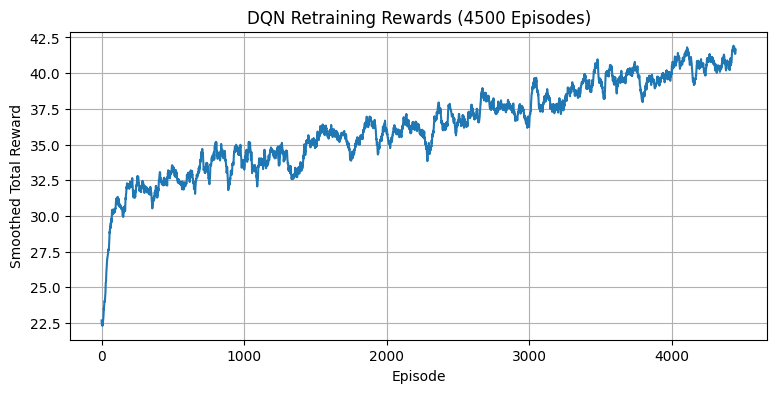

✅ Final retrained model saved to Drive!


In [ ]:
# ======================================================
# 🎵 Multi-Objective Playlist Generator — DQN Retraining
# ======================================================

import time, random, numpy as np, torch, torch.nn as nn, torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from google.colab import drive

# ----------------------------
# 1️⃣ Mount Drive
# ----------------------------
#drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# ----------------------------
# 2️⃣ Define DQN Model
# ----------------------------
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, action_dim)
        )
    def forward(self, x):
        return self.net(x)

# ----------------------------
# 3️⃣ Load Dataset
# ----------------------------
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/PlaylistApp/spotify_clean_subset.csv")
print(f"✅ Loaded dataset with {len(df)} tracks")

# Define features used for training (match your original list)
features = ['tempo', 'energy', 'valence', 'popularity',
            'acousticness'] # Removed 'danceability' and 'liveness'

# ----------------------------
# 4️⃣ Load Previous Checkpoint (Partial Restore)
# ----------------------------
torch.serialization.add_safe_globals([np._core.multiarray._reconstruct])

model_path = "/content/drive/MyDrive/PlaylistRL_Model/trained_dqn_playlist_model.pth"
checkpoint = torch.load(model_path, map_location=device, weights_only=False)
print("✅ Checkpoint loaded from Drive")

# Build new model for current dataset
q_net = DQN(len(features), len(df)).to(device) # Use the updated features list

# Keep matching layers only
state_dict = checkpoint['q_net_state_dict']
model_dict = q_net.state_dict()
filtered = {k: v for k, v in state_dict.items()
            if k in model_dict and model_dict[k].shape == v.shape}
model_dict.update(filtered)
q_net.load_state_dict(model_dict)

print(f"✅ Hidden layers restored; output layer reset for {len(df)} songs")

# Target network & optimizer
target_net = DQN(len(features), len(df)).to(device) # Use the updated features list
target_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

# ----------------------------
# 5️⃣ Reward Function
# ----------------------------
def compute_reward(song1, song2):
    """Higher if tempo/energy/valence/popularity are similar."""
    tempo_diff = abs(song1['tempo'] - song2['tempo'])
    energy_diff = abs(song1['energy'] - song2['energy'])
    valence_diff = abs(song1['valence'] - song2['valence'])
    pop_diff = abs(song1['popularity'] - song2['popularity'])
    genre_bonus = 0.2 if song1['genre'] == song2['genre'] else 0.0
    return max(0, 1.5 - (tempo_diff + energy_diff + valence_diff + pop_diff)) + genre_bonus

# ----------------------------
# 6️⃣ Training Config
# ----------------------------
episodes = 4500
playlist_len = 40
epsilon = 0.2
gamma = 0.9
batch_size = 64
target_update = 50
replay_buffer = deque(maxlen=15000)

def get_state(song):
    return torch.tensor(song[features].values.astype(np.float32),
                        dtype=torch.float32).unsqueeze(0).to(device)

# ----------------------------
# 7️⃣ Retraining Loop
# ----------------------------
rewards_per_episode = []
start_time = time.time()
print("\n🚀 Deep Q-Learning Retraining Started...\n")

for ep in range(episodes):
    idx = random.randint(0, len(df) - 1)
    cur_song = df.iloc[idx]
    total_reward = 0

    for _ in range(playlist_len - 1):
        state = get_state(cur_song)

        # ε-greedy action selection
        if random.random() < epsilon:
            next_idx = random.randint(0, len(df) - 1)
        else:
            with torch.no_grad():
                q_values = q_net(state)
                next_idx = torch.argmax(q_values).item()

        next_song = df.iloc[next_idx]
        reward = compute_reward(cur_song, next_song)
        total_reward += reward
        next_state = get_state(next_song)

        # Store experience
        replay_buffer.append((state, next_idx, reward, next_state))
        cur_song = next_song

        # Train multiple times per step
        for _ in range(3):
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states = torch.cat([b[0] for b in batch])
                actions = torch.tensor([b[1] for b in batch]).long().to(device)
                rewards = torch.tensor([b[2] for b in batch]).float().to(device)
                next_states = torch.cat([b[3] for b in batch])

                # Q(s,a)
                q_pred = q_net(states).gather(1, actions.view(-1,1)).squeeze()

                # Target: r + γ * max(Q'(s'))
                with torch.no_grad():
                    q_next = target_net(next_states).max(1)[0]
                    q_target = rewards + gamma * q_next

                loss = loss_fn(q_pred, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    rewards_per_episode.append(total_reward)

    # Update target net
    if ep % target_update == 0:
        target_net.load_state_dict(q_net.state_dict())

    # Auto-save every 500 episodes
    if ep % 500 == 0 and ep > 0:
        ckpt_path = f"/content/drive/MyDrive/PlaylistRL_Model/retrained_ep{ep}.pth"
        torch.save({
            'q_net_state_dict': q_net.state_dict(),
            'target_net_state_dict': target_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'features': features
        }, ckpt_path)
        print(f"💾 Saved checkpoint at episode {ep}")

    # Progress print
    if ep % 50 == 0:
        elapsed = (time.time() - start_time) / 60
        print(f"Ep {ep:04d}/{episodes} | Reward: {total_reward:.3f} | "
              f"Buffer: {len(replay_buffer)} | Elapsed: {elapsed:.1f} min")

print("\n✅ Retraining Completed!")
print(f"⏱️ Total Time: {(time.time()-start_time)/60:.1f} minutes")

# ----------------------------
# 8️⃣ Plot Reward Curve
# ----------------------------
window = 50
smooth_rewards = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')
plt.figure(figsize=(9,4))
plt.plot(smooth_rewards)
plt.title("DQN Retraining Rewards (4500 Episodes)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Total Reward")
plt.grid(True)
plt.show()

# ----------------------------
# 9️⃣ Save Final Model
# ----------------------------
torch.save({
    'q_net_state_dict': q_net.state_dict(),
    'target_net_state_dict': target_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'features': features
}, "/content/drive/MyDrive/PlaylistRL_Model/trained_dqn_playlist_retrained_final.pth")

print("✅ Final retrained model saved to Drive!")

In [ ]:
import pandas as pd, torch, random
import os
import numpy as np

# Define DQN Model (needs to be defined to load the state_dict)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, action_dim)
        )
    def forward(self, x):
        return self.net(x)

# Load data and model
# Assuming df and features are already loaded and defined in previous cells
# If not, you would need to add code here to load them.
# Example:
# df = pd.read_csv("/content/drive/MyDrive/YourDatasetFolder/your_dataset.csv")
# features = ['tempo', 'energy', 'valence', 'acousticness', 'popularity'] # Example features

# For this fix, we'll assume df and features are available from previous executions.
# If you restart the runtime, you'll need to re-run the data loading and preprocessing steps.

# --- Load the trained model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/PlaylistRL_Model/trained_dqn_playlist_retrained_final.pth" # Use the final retrained model

if not os.path.exists(model_path):
    print(f"Error: Model file not found at {model_path}")
else:
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    # Make sure df and features are defined
    # If not, load them here or ensure previous cells are run
    if 'df' not in locals() or 'features' not in locals():
         print("Warning: df or features not found. Attempting to load dataset...")
         try:
             df = pd.read_csv("/content/drive/MyDrive/PlaylistApp/spotify_clean_subset.csv")
             features = ['tempo', 'energy', 'valence', 'acousticness', 'popularity'] # Assuming these features
             print("Dataset and features loaded.")
         except FileNotFoundError:
             print("Error: Dataset file not found. Please run the data loading cells first.")
             df = pd.DataFrame() # Create empty dataframe to avoid further errors
             features = []
             q_net = None # Set q_net to None to prevent execution

    if df is not None and features:
        # Rebuild the network with same feature count and dataset length
        q_net = DQN(len(features), len(df)).to(device)
        q_net.load_state_dict(checkpoint['q_net_state_dict'])
        q_net.eval() # Set the model to evaluation mode

        print("✅ Trained model loaded successfully.")

        # --- Rest of your code ---
        def compute_reward(song1, song2):
            tempo_diff = abs(song1['tempo'] - song2['tempo'])
            energy_diff = abs(song1['energy'] - song2['energy'])
            valence_diff = abs(song1['valence'] - song2['valence'])
            pop_diff = abs(song1['popularity'] - song2['popularity'])
            genre_bonus = 0.3 if song1['genre'] == song2['genre'] else 0.0

            base_reward = max(0, 1.5 - (tempo_diff + energy_diff + valence_diff + pop_diff)) + genre_bonus
            if song1['track_name'] == song2['track_name']:
                base_reward -= 0.5
            return base_reward

        def get_state(song):
             # Ensure the selected features are converted to a numpy array of float32 before creating the tensor
            return torch.tensor(song[features].values.astype(np.float32), dtype=torch.float32).unsqueeze(0).to(device)


        def generate_playlist(q_net, df, playlist_len=12, top_k=20):
            idx = random.randint(0, len(df) - 1)
            cur_song = df.iloc[idx]
            playlist = [cur_song]
            used_indices = {idx}

            for _ in range(playlist_len - 1):
                state = get_state(cur_song)
                with torch.no_grad():
                    q_values = q_net(state).flatten()
                    topk_indices = torch.topk(q_values, top_k).indices.cpu().numpy()

                # Select one randomly among top candidates not already used
                candidates = [i for i in topk_indices if i not in used_indices]
                if not candidates:
                    candidates = random.sample(range(len(df)), top_k)
                next_idx = random.choice(candidates)


                next_song = df.iloc[next_idx]
                playlist.append(next_song)
                used_indices.add(next_idx)
                cur_song = next_song

            return pd.DataFrame(playlist)

        # Generate and view improved playlist
        playlist_df = generate_playlist(q_net, df, playlist_len=12, top_k=20)
        print("\n🎧 Generated Personalized Playlist:")
        display(playlist_df[['track_name', 'artist_name', 'genre', 'tempo', 'energy', 'valence', 'popularity']])
    else:
        print("Playlist generation skipped due to missing data or features.")

✅ Trained model loaded successfully.

🎧 Generated Personalized Playlist:


,track_name,artist_name,genre,tempo,energy,valence,popularity
4617,Parachute,Deeparture;UOAK;Rubenson,edm,0.380417,0.620448,0.104514,0.474227
7905,Turning My Head,Anja Schneider,edm,0.395697,0.696760,0.238078,0.463918
6122,Tubular Bells - 2016 Remaster,Book Of Love,pop,0.375116,0.951803,0.606391,0.257732
4924,Bella en mi cabeza para siempre,PXNDX,rock,0.522249,0.898585,0.467768,0.422680
2329,(RE)EVOLUTION VOL. 2,Dirt Monkey,world_music,0.401023,0.779097,0.330156,0.247423
6143,Erased,Volumes,rock,0.271524,0.906618,0.368606,0.494845
1163,Bytes,Aril Brikha,edm,0.441308,0.578275,0.326109,0.072165
6128,White Christmas,The Drifters,jazz_blues,0.412657,0.178641,0.479910,0.000000
5804,What He's Done - Live From Passion 2022,Passion;Kristian Stanfill;Tasha Cobbs Leonard;...,world_music,0.484161,0.556185,0.182426,0.515464
2851,Kernkraft 400 (A Better Day),Topic;A7S,edm,0.405630,0.725879,0.401997,0.000000


In [ ]:
print("Avg tempo:", playlist_df['tempo'].mean())
print("Avg energy:", playlist_df['energy'].mean())
print("Avg valence:", playlist_df['valence'].mean())
print("Genre diversity:", playlist_df['genre'].nunique(), "/", len(playlist_df))


Avg tempo: 0.41898505598730895
Avg energy: 0.712156051584313
Avg valence: 0.4355570396003871
Genre diversity: 6 / 12


In [ ]:
import shutil

src = "/content/drive/MyDrive/PlaylistRL_Model/trained_dqn_playlist_retrained_final.pth"
dst = "/content/drive/MyDrive/PlaylistApp/trained_dqn_playlist_final_v2.pth"

shutil.copy(src, dst)
print("✅ Model copied successfully to PlaylistApp folder!")


✅ Model copied successfully to PlaylistApp folder!


In [ ]:
import os
print("Exists in PlaylistApp:", os.path.exists(dst))


Exists in PlaylistApp: True


In [ ]:
!streamlit run /content/drive/MyDrive/PlaylistApp/app.py


/bin/bash: line 1: streamlit: command not found


In [ ]:
print(df.columns.tolist())


['track_id', 'track_name', 'artist_name', 'genre', 'tempo', 'energy', 'valence', 'acousticness', 'popularity', 'genre_code']


Load the Model Back from Drive (Anytime Later)

🧠 5️⃣ (Optional) Check Model Output

In [ ]:
idx = random.randint(0, len(df)-1)
state = get_state(df.iloc[idx])
with torch.no_grad():
    q_values = q_net(state)
print("Output shape:", q_values.shape)


In [ ]:
!mkdir -p /content/drive/MyDrive/PlaylistApp
%cd /content/drive/MyDrive/PlaylistApp


/content/drive/MyDrive/PlaylistApp


# WEBSITE

In [ ]:
!pip install spotipy streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.9/339.9 kB 22.3 MB/s eta 0:00:00


In [ ]:
%%writefile /content/drive/MyDrive/PlaylistApp/app.py
import streamlit as st
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import uuid
import gdown
# ==========================================
# ❤️ Initialize Session State
# ==========================================
if "liked_songs" not in st.session_state:
    st.session_state.liked_songs = []
if "playlist_df" not in st.session_state:
    st.session_state.playlist_df = pd.DataFrame()

# ==========================================
# 🎧 DQN Model Definition
# ==========================================
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# ==========================================
# ⚙️ Load Model & Dataset
# ==========================================
@st.cache_resource
def load_model_and_data():
    # Load CSV
    csv_path = "spotify_clean_subset.csv"
    if not os.path.exists(csv_path):
        st.error("❌ 'spotify_clean_subset.csv' file is missing.")
        st.stop()

    df = pd.read_csv(csv_path)
    features = ['tempo', 'energy', 'valence', 'acousticness', 'popularity']

    # Load model
    model_path = "trained_dqn_playlist_final_v2.pth"
    gdrive_id = "1V8B5GRRX3rOY4BucMjukPiwTK_oLdDoa"
    if not os.path.exists(model_path):
        st.warning("Downloading model from Google Drive ⏳ ...")
        url = f"https://drive.google.com/uc?id={gdrive_id}"
        gdown.download(url, model_path, quiet=False)
        st.success("✅ Model downloaded successfully!")

    checkpoint = torch.load(model_path, map_location="cpu")
    q_net = DQN(len(checkpoint['features']), len(df))
    q_net.load_state_dict(checkpoint['q_net_state_dict'], strict=False)
    q_net.eval()

    st.success("✅ Model and dataset loaded successfully.")
    return q_net, df, features



# Load model and data once
q_net, df, features = load_model_and_data()

# ==========================================
# 🎨 Spotify API Setup
# ==========================================
client_id = "b166c71602014354b5c135a15c185f74"
client_secret = "fd57730a9ef541d8974c78205125d50b"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

def get_spotify_data(track_name, artist_name):
    try:
        query = f"{track_name} {artist_name}"
        result = sp.search(q=query, limit=1, type="track")
        if result["tracks"]["items"]:
            track = result["tracks"]["items"][0]
            return {
                "cover_url": track["album"]["images"][0]["url"] if track["album"]["images"] else None,
                "preview_url": track["preview_url"],
                "spotify_url": track["external_urls"]["spotify"]
            }
    except:
        pass
    return {"cover_url": None, "preview_url": None, "spotify_url": None}

# ==========================================
# 🧠 Helper Functions
# ==========================================
def get_state(song):
    return torch.tensor(song[features].values.astype(np.float32), dtype=torch.float32).unsqueeze(0)

def generate_playlist(q_net, df, start_genre=None, mood=None, playlist_len=10, top_k=20):
    """
    Generate a playlist using the trained DQN model with genre & mood filters.
    Prevents duplicate songs and index-out-of-bound errors.
    """

    # 🎧 Apply genre filter
    if start_genre and start_genre != "Any":
        genre_subset = df[df['genre'].str.lower() == start_genre.lower()]
        if genre_subset.empty:
            st.warning(f"⚠️ No tracks found for genre '{start_genre}'. Using full dataset.")
        else:
            df = genre_subset.reset_index(drop=True)

    # 🎭 Apply mood filter
    if mood and mood != "Any":
        if mood == "Energetic":
            df = df[df['energy'] > 0.7]
        elif mood == "Calm":
            df = df[df['energy'] < 0.4]
        elif mood == "Happy":
            df = df[df['valence'] > 0.6]
        elif mood == "Sad":
            df = df[df['valence'] < 0.3]

    df = df.reset_index(drop=True)
    n_songs = len(df)
    if n_songs == 0:
        st.error("⚠️ No songs match the selected filters.")
        return pd.DataFrame()

    # 🎵 Start with a random song
    idx = random.randint(0, n_songs - 1)
    cur_song = df.iloc[idx]
    playlist = [cur_song]
    used_indices = {idx}

    for _ in range(playlist_len - 1):
        # Prepare state vector safely
        state = torch.tensor(
            cur_song[features].values.astype(np.float32),
            dtype=torch.float32
        ).unsqueeze(0)

        # Predict Q-values and add slight randomness for exploration
        with torch.no_grad():
            q_values = q_net(state).flatten()
            q_values += torch.rand_like(q_values) * 0.01  # adds variety

        k = min(top_k, n_songs)
        topk_indices = torch.topk(q_values, k).indices.cpu().numpy()

        # ⚡ Only keep valid indices
        topk_indices = [i for i in topk_indices if 0 <= i < n_songs]
        candidates = [i for i in topk_indices if i not in used_indices]

        # Handle out-of-bound or exhausted candidate cases
        if not candidates:
            remaining = list(set(range(n_songs)) - used_indices)
            if not remaining:
                break  # no more songs left
            next_idx = random.choice(remaining)
        else:
            next_idx = random.choice(candidates)

        # ✅ Double-check that index is valid before accessing
        if 0 <= next_idx < n_songs:
            next_song = df.iloc[next_idx]
            playlist.append(next_song)
            used_indices.add(next_idx)
            cur_song = next_song
        else:
            continue  # skip invalid index safely

    # ✅ Remove duplicates by track name
    playlist_df = pd.DataFrame(playlist).drop_duplicates(subset=['track_name']).reset_index(drop=True)
    return playlist_df



# ==========================================
# 🎨 Streamlit UI
# ==========================================
st.set_page_config(page_title="AI Playlist Generator", page_icon="🎧", layout="wide")

st.markdown("<h1 style='text-align:center;color:#1DB954;'>🎧 AI Playlist Generator</h1>", unsafe_allow_html=True)
st.markdown("<h4 style='text-align:center;'>Personalized Mood-Based Playlists using Reinforcement Learning + Spotify API</h4>", unsafe_allow_html=True)
st.markdown("---")

# Sidebar Controls
st.sidebar.header("⚙️ Playlist Settings")
playlist_len = st.sidebar.slider("Playlist length", 5, 20, 10)
top_k = st.sidebar.slider("Exploration (Top-K Sampling)", 5, 50, 20)
start_genre = st.sidebar.selectbox("Preferred Genre", ["Any"] + sorted(df['genre'].unique().tolist()))
mood = st.sidebar.selectbox("Select Mood 🎭", ["Any", "Happy", "Calm", "Energetic", "Sad"])

# Generate Button
if st.button("✨ Generate Playlist"):
    st.session_state.playlist_df = generate_playlist(q_net, df, start_genre=start_genre, mood=mood, playlist_len=playlist_len, top_k=top_k)
    st.success("✅ Playlist Generated Successfully!")

# ==========================================
# 🎶 Display Generated Playlist (Fixed Likes)
# ==========================================
if not st.session_state.playlist_df.empty:
    st.markdown("### 🎧 Generated Playlist")

    for i, row in st.session_state.playlist_df.iterrows():
        meta = get_spotify_data(row['track_name'], row['artist_name'])
        cover = meta["cover_url"] or "https://via.placeholder.com/100x100?text=No+Cover"

        # Unique key based on song + index
        song_key = f"{row['track_name']}_{i}"

        with st.container():
            cols = st.columns([1, 3, 1])

            with cols[0]:
                st.image(cover, width=90)

            with cols[1]:
                st.markdown(f"**{row['track_name']}**  \n*{row['artist_name']}*  \n🎵 *{row['genre']}*")

                # Play audio preview or Spotify embed
                if meta["preview_url"]:
                    st.audio(meta["preview_url"], format="audio/mp3")
                elif meta["spotify_url"]:
                    track_id = meta["spotify_url"].split("/")[-1]
                    embed_html = f"""
                    <iframe src="https://open.spotify.com/embed/track/{track_id}"
                            width="100%" height="80" frameborder="0"
                            allowtransparency="true" allow="encrypted-media"></iframe>
                    """
                    st.markdown(embed_html, unsafe_allow_html=True)
                else:
                    st.info("🎧 No preview or embed available.")

            with cols[2]:
                like_button = st.button("❤️ Like", key=f"like_{song_key}")
                if like_button:
                    liked_entry = {
                        "track": row['track_name'],
                        "artist": row['artist_name'],
                        "spotify_url": meta["spotify_url"]
                    }
                    # Prevent duplicates
                    if liked_entry not in st.session_state.liked_songs:
                        st.session_state.liked_songs.append(liked_entry)
                        st.toast(f"💖 Added {row['track_name']} to Liked Songs!")

                if meta["spotify_url"]:
                    st.markdown(f"[🔗 Open in Spotify]({meta['spotify_url']})")


# ==========================================
# 💖 Display Liked Songs
# ==========================================
if st.session_state.liked_songs:
    st.markdown("---")
    st.markdown("### 💖 My Liked Songs")
    for song in st.session_state.liked_songs:
        st.markdown(f"• **[{song['track']}]({song['spotify_url']})** — *{song['artist']}*")

    if st.button("🧹 Clear Liked Songs"):
        st.session_state.liked_songs.clear()
        st.success("Cleared liked songs list!")

# ==========================================
# 🔍 Spotify Search Section
# ==========================================
st.markdown("---")
st.markdown("## 🔍 Search Songs on Spotify")

search_query = st.text_input("Type a song or artist name", placeholder="e.g., Blinding Lights or Arijit Singh")

if st.button("🔎 Search Spotify"):
    if search_query.strip():
        results = sp.search(q=search_query, limit=5, type="track")
        tracks = results["tracks"]["items"]

        if len(tracks) == 0:
            st.warning("No songs found. Try another search!")
        else:
            for track in tracks:
                track_name = track["name"]
                artist = track["artists"][0]["name"]
                album = track["album"]["name"]
                url = track["external_urls"]["spotify"]
                cover = track["album"]["images"][0]["url"] if track["album"]["images"] else "https://via.placeholder.com/150"

                embed_html = f"""
                <iframe src="https://open.spotify.com/embed/track/{track['id']}"
                        width="100%" height="80" frameborder="0"
                        allowtransparency="true" allow="encrypted-media"></iframe>
                """

                with st.container():
                    cols = st.columns([1, 3])
                    with cols[0]:
                        st.image(cover, width=100)
                    with cols[1]:
                        st.markdown(f"**{track_name}** — *{artist}*  \n💿 {album}")
                        st.markdown(embed_html, unsafe_allow_html=True)
    else:
        st.warning("Please enter a search query.")

# ==========================================
# 📝 Footer
# ==========================================
st.markdown("---")
st.markdown(
    "<center><h4>🎶 Built with ❤️ using PyTorch + Streamlit + Spotify API<br>SR University — AI Playlist Project</h4></center>",
    unsafe_allow_html=True
)


Overwriting /content/drive/MyDrive/PlaylistApp/app.py


In [ ]:
!pip install streamlit pyngrok -q

In [ ]:
from pyngrok import ngrok

# Terminate open tunnels if any
ngrok.kill()

# Set your authtoken here. Replace "YOUR_AUTHTOKEN" with your actual ngrok authtoken.
# You can get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
!ngrok authtoken "34aheODnO9cGcWMVfFdO3vd9FzG_7NWadUxb8hLqhPchdgxXt"


!streamlit run /content/drive/MyDrive/PlaylistApp/app.py &>/dev/null&
public_url = ngrok.connect(8501)
public_url

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


<NgrokTunnel: "https://nery-unintoned-gloomily.ngrok-free.dev" -> "http://localhost:8501">

dont run


In [ ]:
%%writefile /content/drive/MyDrive/PlaylistApp/app.py

import streamlit as st
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import os
import uuid
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# ==========================================
# ❤️ Initialize Session State
# ==========================================
if "liked_songs" not in st.session_state:
    st.session_state.liked_songs = []
if "playlist_df" not in st.session_state:
    st.session_state.playlist_df = pd.DataFrame()
if "current_song_idx" not in st.session_state:
    st.session_state.current_song_idx = None

# ==========================================
# 🎧 DQN Model Definition
# ==========================================
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# ==========================================
# ⚙️ Load Model & Dataset
# ==========================================
@st.cache_resource
def load_model_and_data():
    csv_path = "/content/drive/MyDrive/PlaylistApp/spotify_clean_subset.csv"
    model_path = "/content/drive/MyDrive/PlaylistApp/trained_dqn_playlist_final_v2.pth"

    if not os.path.exists(csv_path):
        st.error("❌ 'spotify_clean_subset.csv' file missing.")
        st.stop()

    if not os.path.exists(model_path):
        st.error("❌ Model file 'trained_dqn_playlist_final_v2.pth' missing.")
        st.stop()

    df = pd.read_csv(csv_path)
    features = ['tempo', 'energy', 'valence', 'acousticness', 'popularity']

    checkpoint = torch.load(model_path, map_location="cpu")
    q_net = DQN(len(checkpoint['features']), len(df))
    q_net.load_state_dict(checkpoint['q_net_state_dict'], strict=False)
    q_net.eval()

    return q_net, df, features

q_net, df, features = load_model_and_data()

# ==========================================
# 🎨 Spotify API Setup
# ==========================================
client_id = "b166c71602014354b5c135a15c185f74"
client_secret = "fd57730a9ef541d8974c78205125d50b"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

def get_spotify_data(track_name, artist_name):
    try:
        result = sp.search(q=f"{track_name} {artist_name}", limit=1, type="track")
        if result["tracks"]["items"]:
            track = result["tracks"]["items"][0]
            return {
                "cover_url": track["album"]["images"][0]["url"] if track["album"]["images"] else None,
                "preview_url": track["preview_url"],
                "spotify_url": track["external_urls"]["spotify"]
            }
    except:
        pass
    return {"cover_url": None, "preview_url": None, "spotify_url": None}

# ==========================================
# 🧠 Adaptive Playlist Generator
# ==========================================
def generate_adaptive_playlist(q_net, df, start_song_idx=None, playlist_len=10, top_k=20):
    n_songs = len(df)
    if start_song_idx is None:
        start_song_idx = random.randint(0, n_songs - 1)

    cur_song = df.iloc[start_song_idx]
    playlist = [cur_song]
    used_indices = {start_song_idx}

    for _ in range(playlist_len - 1):
        state = torch.tensor(cur_song[features].values.astype(np.float32),
                             dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = q_net(state).flatten()
            q_values += torch.rand_like(q_values) * 0.02  # random boost for diversity
            topk_indices = torch.topk(q_values, min(top_k, n_songs)).indices.cpu().numpy()

        candidates = [i for i in topk_indices if i not in used_indices]
        if not candidates:
            break

        # pick a next song that has a similar vibe
        next_idx = random.choice(candidates)
        next_song = df.iloc[next_idx]
        if abs(next_song['energy'] - cur_song['energy']) < 0.3 and abs(next_song['valence'] - cur_song['valence']) < 0.3:
            playlist.append(next_song)
            used_indices.add(next_idx)
            cur_song = next_song

    playlist_df = pd.DataFrame(playlist).drop_duplicates(subset=['track_name']).reset_index(drop=True)
    return playlist_df

# ==========================================
# 🎨 Streamlit UI
# ==========================================
st.set_page_config(page_title="AI Playlist Generator", page_icon="🎧", layout="wide")

st.markdown("<h1 style='text-align:center;color:#1DB954;'>🎧 Adaptive AI Playlist Generator</h1>", unsafe_allow_html=True)
st.markdown("<h4 style='text-align:center;'>Automatic Mood-Aware Music Recommender using DQN + Spotify API</h4>", unsafe_allow_html=True)
st.markdown("---")

playlist_len = st.sidebar.slider("🎵 Playlist Length", 5, 20, 10)
top_k = st.sidebar.slider("🎯 Exploration (Top-K Sampling)", 5, 50, 20)

# ==========================================
# 🎶 Generate / Continue Playlist
# ==========================================
col1, col2 = st.columns(2)
with col1:
    if st.button("✨ Generate New Playlist"):
        st.session_state.playlist_df = generate_adaptive_playlist(q_net, df, playlist_len=playlist_len, top_k=top_k)
        st.session_state.current_song_idx = 0
        st.success("✅ Playlist generated successfully!")

with col2:
    if st.button("🔁 Continue Playlist"):
        if not st.session_state.playlist_df.empty:
            last_idx = st.session_state.playlist_df.index[-1]
            extra = generate_adaptive_playlist(q_net, df, start_song_idx=last_idx, playlist_len=5, top_k=top_k)
            st.session_state.playlist_df = pd.concat([st.session_state.playlist_df, extra]).drop_duplicates().reset_index(drop=True)
            st.success("🎶 Playlist extended!")

# ==========================================
# 🎵 Display Playlist
# ==========================================
if not st.session_state.playlist_df.empty:
    st.markdown("### 🎧 Generated Playlist")
    for i, row in st.session_state.playlist_df.iterrows():
        meta = get_spotify_data(row['track_name'], row['artist_name'])
        cover = meta["cover_url"] or "https://via.placeholder.com/100x100?text=No+Cover"

        with st.container():
            cols = st.columns([1, 3, 1])
            with cols[0]:
                st.image(cover, width=90)
            with cols[1]:
                st.markdown(f"**{row['track_name']}** — *{row['artist_name']}*  \n🎵 {row['genre']}")
                if meta["preview_url"]:
                    st.audio(meta["preview_url"], format="audio/mp3")
                elif meta["spotify_url"]:
                    track_id = meta["spotify_url"].split("/")[-1]
                    st.markdown(
                        f'<iframe src="https://open.spotify.com/embed/track/{track_id}" '
                        'width="100%" height="80" frameborder="0" allow="encrypted-media"></iframe>',
                        unsafe_allow_html=True
                    )
            with cols[2]:
                if st.button("❤️ Like", key=f"like_{uuid.uuid4()}"):
                    st.session_state.liked_songs.append({
                        "track": row['track_name'],
                        "artist": row['artist_name'],
                        "spotify_url": meta["spotify_url"]
                    })
                if meta["spotify_url"]:
                    st.markdown(f"[🔗 Spotify]({meta['spotify_url']})")

# ==========================================
# 💖 Liked Songs Section
# ==========================================
if st.session_state.liked_songs:
    st.markdown("---")
    st.markdown("### 💖 My Liked Songs")
    for s in st.session_state.liked_songs:
        st.markdown(f"• **[{s['track']}]({s['spotify_url']})** — *{s['artist']}*")

    if st.button("🧹 Clear Liked Songs"):
        st.session_state.liked_songs.clear()
        st.success("✅ Liked songs cleared!")

# ==========================================
# 🔍 Spotify Search Section
# ==========================================
st.markdown("---")
st.markdown("## 🔍 Search Songs on Spotify")
query = st.text_input("Search for a song or artist", placeholder="e.g. Blinding Lights or Arijit Singh")

if st.button("🔎 Search Spotify"):
    if query.strip():
        results = sp.search(q=query, limit=5, type="track")
        for track in results["tracks"]["items"]:
            name = track["name"]
            artist = track["artists"][0]["name"]
            album = track["album"]["name"]
            url = track["external_urls"]["spotify"]
            cover = track["album"]["images"][0]["url"] if track["album"]["images"] else None
            st.markdown(f"**{name}** — *{artist}*  \n💿 {album}")
            st.image(cover, width=100)
            st.markdown(f'<iframe src="https://open.spotify.com/embed/track/{track["id"]}" width="100%" height="80" frameborder="0" allow="encrypted-media"></iframe>', unsafe_allow_html=True)
    else:
        st.warning("Please enter a search term!")

# ==========================================
# 📝 Footer
# ==========================================
st.markdown("---")
st.markdown(
    "<center><h4>🎶 Built with ❤️ using PyTorch, Streamlit & Spotify API<br>AI-Driven Adaptive Playlist Generator</h4></center>",
    unsafe_allow_html=True
)


In [ ]:
# Create requirements.txt in your PlaylistApp folder
with open("/content/drive/MyDrive/PlaylistApp/requirements.txt", "w") as f:
    f.write("""streamlit
torch
pandas
numpy
spotipy
requests
matplotlib
""")

print("✅ requirements.txt created successfully in PlaylistApp!")


✅ requirements.txt created successfully in PlaylistApp!


In [ ]:
!cat /content/drive/MyDrive/PlaylistApp/requirements.txt


streamlit
torch
pandas
numpy
pyngrok
matplotlib


In [ ]:
!pip install pyngrok


In [ ]:
from pyngrok import ngrok
!ngrok authtoken "34aheODnO9cGcWMVfFdO3vd9FzG_7NWadUxb8hLqhPchdgxXt"


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
#!pip install streamlit pyngrok
from pyngrok import ngrok

# Terminate open tunnels if any
ngrok.kill()

!streamlit run app.py &>/dev/null&
public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "https://nery-unintoned-gloomily.ngrok-free.dev" -> "http://localhost:8501">

In [ ]:
!cp /content/drive/MyDrive/PlaylistRL_Model/trained_dqn_playlist_model.pth /content/drive/MyDrive/PlaylistApp/


In [ ]:
df.to_csv("/content/drive/MyDrive/PlaylistApp/spotify_clean_subset.csv", index=False)
print("✅ Saved dataset to Drive: /content/drive/MyDrive/PlaylistApp/spotify_clean_subset.csv")


✅ Saved dataset to Drive: /content/drive/MyDrive/PlaylistApp/spotify_clean_subset.csv


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/PlaylistApp/spotify_clean_subset.csv")
print(df.head())


                 track_id                                         track_name  \
0  6KwkVtXm8OUp2XffN5k7lY                                      No Other Name   
1  75hT0hvlESnDJstem0JgyR                                    Merry Christmas   
2  2zQt5C0AIv27RhfJCRZdZ4                             Jah Jah Revolta, Pt. 2   
3  1LDQFdGTEXOnycDC8CJ5p1                                  A Form of Protest   
4  4ifiz8TRTNdG9ORNWh2P0Q  I'll Be Home For Christmas - From The Kacey Mu...   

                    artist_name        genre     tempo    energy   valence  \
0              Hillsong Worship  world_music  0.517211  0.596349  0.044410   
1                   Bryan Adams         rock  0.324704  0.508992  0.602343   
2                  BaianaSystem  world_music  0.496833  0.799179  0.587166   
3                     Cane Hill         rock  0.236301  0.932725  0.193557   
4  Kacey Musgraves;Lana Del Rey         folk  0.474572  0.179645  0.382772   

   acousticness  popularity  genre_code  
0      0

In [ ]:
%%writefile /content/drive/MyDrive/PlaylistApp/model_def.py
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, action_dim)
        )

    def forward(self, x):
        return self.net(x)


Overwriting /content/drive/MyDrive/PlaylistApp/model_def.py


In [ ]:
!pip install streamlit pyngrok
from pyngrok import ngrok

!streamlit run /content/drive/MyDrive/PlaylistApp/app.py &>/dev/null&
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://nery-unintoned-gloomily.ngrok-free.dev" -> "http://localhost:8501">

In [ ]:
!pip install spotipy


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# 🔑 Replace these with your real credentials
CLIENT_ID = "b166c71602014354b5c135a15c185f74"
CLIENT_SECRET = "fd57730a9ef541d8974c78205125d50b"

# Authenticate
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET
))

# 🎵 Test: Search for a song
result = sp.search(q="Believer Imagine Dragons", limit=1, type="track")

# Print some info
track = result["tracks"]["items"][0]
print("✅ Spotify API working!")
print("Track Name:", track["name"])
print("Artist:", track["artists"][0]["name"])
print("Album:", track["album"]["name"])
print("Preview URL:", track["preview_url"])
print("Cover Art URL:", track["album"]["images"][0]["url"])


✅ Spotify API working!
Track Name: Believer
Artist: Imagine Dragons
Album: Evolve
Preview URL: None
Cover Art URL: https://i.scdn.co/image/ab67616d0000b2735675e83f707f1d7271e5cf8a
